# Goal of this Notebook
- Goal of this notebook to use our custom model and then use the pre-train model and check the performance and results

# Transfer Learing
- Transfer Learing is a technique where we can use the other model that is already trained on vast amount of data and we can use them in our data and update the only necessary layers.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision import transforms
import random

In [2]:
# !export CUDA_LAUNCH_BLOCKING=1

# Data Loading
- !kaggle datasets download -d muratkokludataset/rice-image-dataset

In [3]:
# !kaggle datasets download -d muratkokludataset/rice-image-dataset

In [4]:
# !unzip rice-image-dataset.zip

# Note
- Remove the `.txt` file first before moeving to next

# Data Preprocessing


In [5]:
import os
from PIL import Image

In [6]:
def remove_corrupt_images(main_path):
    try:
        dirs = os.listdir('Rice_Image_Dataset')

        for img_folder in dirs:
            img_dir = os.path.join('Rice_Image_Dataset',img_folder)
            if os.path.isdir(img_dir):
                # get the image image
                for img in os.listdir(img_dir):
                    if img.endswith('.jpg') or img.endswith('.jpeg') or img.endswith('.png'):
                        try:
                            img_path = os.path.join(img_dir,img)
                            img = Image.open(img_path)
                            img.verify()
                        except Exception as e:
                            print(e)
                    else:
                        print(f"Corrupted images {img}")
                        os.remove(os.path.join(img_dir,img))

    except Exception as e:
        return e

In [7]:
# Apply the function
remove_corrupt_images('Rice_Image_Dataset')

# visulize data

In [8]:
import matplotlib.pyplot as plt
import random

# Function to display random images from each rice variety
def visualize_images(data_dir, num_images_per_variety=3):
    """Visualizes random images from each rice variety."""

    try:
        variety_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

        plt.figure(figsize=(15, 5 * len(variety_folders)))  # Adjust figure size based on number of varieties

        for i, variety in enumerate(variety_folders):
            variety_path = os.path.join(data_dir, variety)
            images = [f for f in os.listdir(variety_path) if os.path.isfile(os.path.join(variety_path, f)) and (f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png'))]
            random_images = random.sample(images, min(num_images_per_variety, len(images)))

            for j, image_name in enumerate(random_images):
                image_path = os.path.join(variety_path, image_name)
                img = Image.open(image_path)
                plt.subplot(len(variety_folders), num_images_per_variety, i * num_images_per_variety + j + 1)
                plt.imshow(img)
                plt.title(f"{variety} - {image_name}")
                plt.axis('off')  # Turn off axis ticks and labels

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

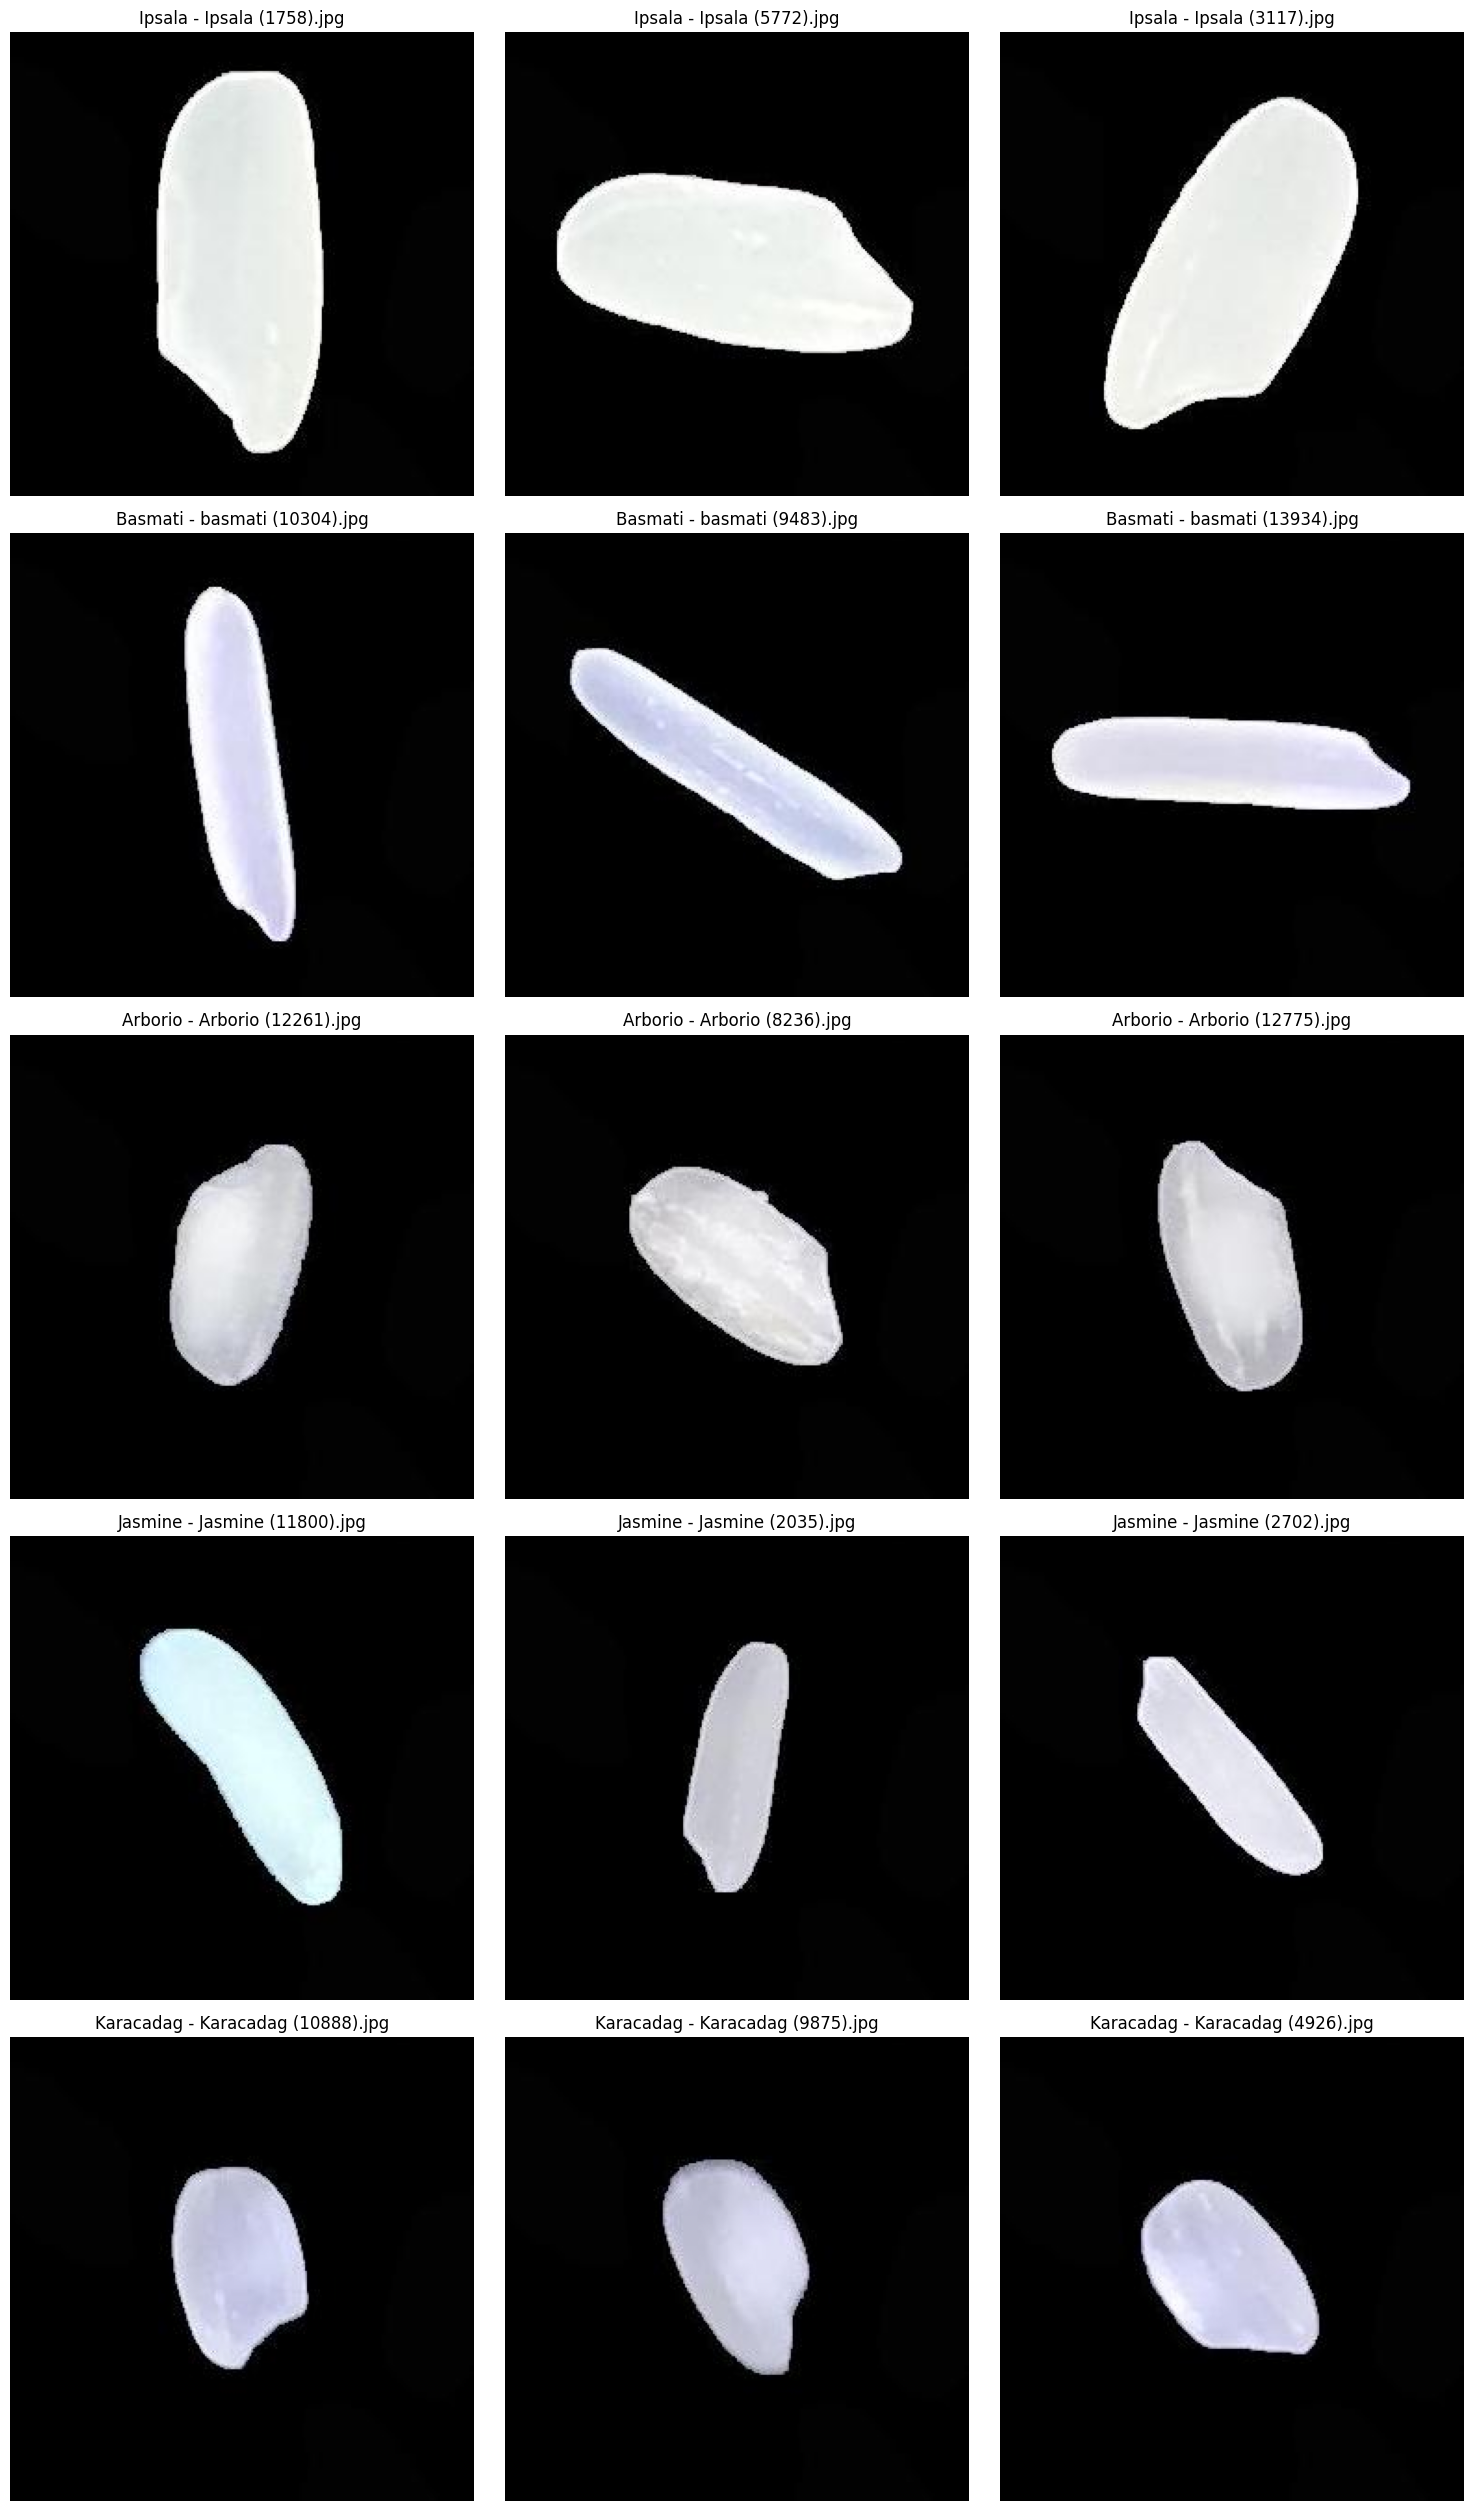

In [9]:
# Apply the visualization function
visualize_images('Rice_Image_Dataset')

In [10]:
# Build Custom Data Loading Class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label,image_folder in enumerate(os.listdir(self.root_dir)):
            # print(label)
            # verify the folder
            img_folder = os.path.join(self.root_dir,image_folder)
            if os.path.isdir(img_folder):
                print(img_folder)
                # get the image path
                for img in os.listdir(img_folder):
                    # get the image full path
                    img_path = os.path.join(img_folder,img)
                    self.image_paths.append(img_path)
                    # print(label)
                    self.labels.append(label-1)
            else:
                print(f"{img_folder} is not a folder")
        # print(self.labels)
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,idx):
        # get the image and label path
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        # read the image
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image,label

In [11]:
# Define transformations (adjust as needed)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Train data
data = CustomDataset(root_dir="/content/Rice_Image_Dataset",
                     transform=transform)
data

/content/Rice_Image_Dataset/.ipynb_checkpoints
/content/Rice_Image_Dataset/Ipsala
/content/Rice_Image_Dataset/Basmati
/content/Rice_Image_Dataset/Arborio
/content/Rice_Image_Dataset/Jasmine
/content/Rice_Image_Dataset/Karacadag


In [12]:
print("Length of data is: ",len(data))

Length of data is:  75000


# Split the Data

In [13]:
from torch.utils.data import random_split

# Define the proportions for train, validation, and test sets
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

# Calculate the sizes of each set
total_size = len(data)
train_size = int(train_ratio * total_size)
test_size = int(test_ratio * total_size)
val_size = total_size - train_size - test_size  # Ensuring the split adds up to the total

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(data, [train_size, val_size, test_size])

In [14]:
print("Length of train data: ",len(train_dataset))
print("Length of val data: ",len(val_dataset))
print("Length of test data: ",len(test_dataset))

Length of train data:  52500
Length of val data:  11250
Length of test data:  11250


# Make Data-Loader

In [32]:
# Create data loaders for each split

# Test loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# Val loader
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [33]:
# View the Batch Size
for image, label in train_loader:
    print(image.shape)
    print(label)
    break

torch.Size([64, 3, 224, 224])
tensor([3, 0, 2, 1, 1, 2, 0, 2, 4, 4, 2, 0, 2, 3, 4, 2, 4, 0, 4, 2, 1, 1, 1, 1,
        2, 3, 1, 0, 3, 1, 2, 4, 3, 2, 0, 3, 1, 2, 4, 3, 3, 3, 2, 3, 3, 0, 1, 3,
        0, 2, 0, 1, 1, 1, 3, 3, 4, 4, 0, 3, 1, 4, 1, 1])


# Custom Modle

In [24]:
import torch
import torch.nn as nn

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)

        # Define activation and pooling
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 pooling reduces dimensions

        # Fully connected layer
        # Using manually calculated in_features for input 224x224
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=128 * 28 * 28, out_features=5)  # Adjust `in_features` for your data

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.pool(self.relu(self.conv1(x)))  # Output: [32, 112, 112]
        x = self.pool(self.relu(self.conv2(x)))  # Output: [64, 56, 56]
        x = self.pool(self.relu(self.conv3(x)))  # Output: [128, 28, 28]

        # Flatten and pass through fully connected layer
        x = self.flatten(x)  # Flatten to shape [batch_size, 128*28*28]
        # print(f"Flattened size: {x.shape}")
        x = self.fc(x)
        return x

In [34]:
# Initilize the model
model = MyCNN()
model

MyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=100352, out_features=5, bias=True)
)

In [35]:
# set the loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

loss_fn, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [27]:
# Set the model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Make training Loop

In [28]:
from tqdm import tqdm

In [36]:
# define the eval fun
def evulation(epoch):
    model.eval()
    with torch.no_grad():
        test_loss = 0
        num_correct = 0
        num_samples = 0
        for image, label in tqdm(test_loader):
            image = image.to(device)
            label = label.to(device)

            # do forward pass
            output = model(image)

            # calculate the loss
            loss = loss_fn(output,label)

            test_loss += loss.item()

            # calculate the accuracy
            _,prediction = output.max(1)
            num_correct += (prediction == label).sum()
            num_samples += prediction.size(0)

        accuracy = num_correct/num_samples
        print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {accuracy * 100:.2f}%")

In [39]:
model = model.to(device)
epochs = 5
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")
    model.train()
    train_loss = 0
    num_correct = 0
    num_samples = 0
    for image, label in tqdm(train_loader):
        image = image.to(device)
        label = label.to(device)
        # print(label.shape)
        # print(image.shape)
        # do forward pass
        output = model(image)

        # Calculate the loss
        loss = loss_fn(output,label)

        # Set the optimizer to zero_grad
        optimizer.zero_grad()

        # do backward
        loss.backward()

        optimizer.step()

        train_loss +=loss.item()

        # calculate the accuracy
        _, prediction = output.max(1)
        num_correct += (prediction == label).sum()
        num_samples += prediction.size(0)

    # calculate the accuracy
    accuracy = num_correct/num_samples
    print(f"Epoch: {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {accuracy * 100:.2f}%")
    evulation(epoch)

Epoch: 1/5


100%|██████████| 821/821 [03:48<00:00,  3.60it/s]


Epoch: 1/5, Train Loss: 0.0559, Train Accuracy: 98.24%


100%|██████████| 176/176 [00:39<00:00,  4.43it/s]


Test Loss: 0.0198, Test Accuracy: 99.38%
Epoch: 2/5


100%|██████████| 821/821 [03:48<00:00,  3.60it/s]


Epoch: 2/5, Train Loss: 0.0307, Train Accuracy: 99.06%


100%|██████████| 176/176 [00:39<00:00,  4.47it/s]


Test Loss: 0.0222, Test Accuracy: 99.32%
Epoch: 3/5


100%|██████████| 821/821 [03:43<00:00,  3.67it/s]


Epoch: 3/5, Train Loss: 0.0241, Train Accuracy: 99.24%


100%|██████████| 176/176 [00:39<00:00,  4.44it/s]


Test Loss: 0.0134, Test Accuracy: 99.59%
Epoch: 4/5


100%|██████████| 821/821 [03:47<00:00,  3.61it/s]


Epoch: 4/5, Train Loss: 0.0252, Train Accuracy: 99.22%


100%|██████████| 176/176 [00:40<00:00,  4.39it/s]


Test Loss: 0.0154, Test Accuracy: 99.57%
Epoch: 5/5


100%|██████████| 821/821 [03:46<00:00,  3.62it/s]


Epoch: 5/5, Train Loss: 0.0161, Train Accuracy: 99.50%


100%|██████████| 176/176 [00:39<00:00,  4.47it/s]

Test Loss: 0.0081, Test Accuracy: 99.73%


# Evulation On Validtion Data

In [43]:
# define the eval fun
def model_valiation():
    model.eval()
    with torch.no_grad():
        test_loss = 0
        num_correct = 0
        num_samples = 0
        for image, label in tqdm(val_loader):
            image = image.to(device)
            label = label.to(device)

            # do forward pass
            output = model(image)

            # calculate the loss
            loss = loss_fn(output,label)

            test_loss += loss.item()

            # calculate the accuracy
            _,prediction = output.max(1)
            num_correct += (prediction == label).sum()
            num_samples += prediction.size(0)

        accuracy = num_correct/num_samples
        print(f"Val Loss: {test_loss / len(test_loader):.4f}, Val Accuracy: {accuracy * 100:.2f}%")

In [44]:
model_valiation()

100%|██████████| 176/176 [00:39<00:00,  4.45it/s]

Val Loss: 0.0086, Val Accuracy: 99.75%


# Observation

In [46]:
# save the model
model_path = "Models/custom_cnn_model.pth"
torch.save(model.state_dict(),model_path)

# Pre-Train Model
- We can use the VGG16 as a pretrain model

# Load the Vgg16 Model

In [47]:
from torchvision import models

In [49]:
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.0MB/s]


In [50]:
# freeze the layers
for params in vgg16.parameters():
    params.requires_grad = False

In [51]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [52]:
# Update the classification head
vgg16.classifier[6] = nn.Linear(4096, 5)

In [53]:
# Unfreeze the updates layers
for params in vgg16.classifier[6].parameters():
    params.requires_grad = True

In [54]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [55]:
# Load the data again
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Train data
data = CustomDataset(root_dir="/content/Rice_Image_Dataset",
                     transform=transform)
data

/content/Rice_Image_Dataset/.ipynb_checkpoints
/content/Rice_Image_Dataset/Ipsala
/content/Rice_Image_Dataset/Basmati
/content/Rice_Image_Dataset/Arborio
/content/Rice_Image_Dataset/Jasmine
/content/Rice_Image_Dataset/Karacadag


In [56]:
from torch.utils.data import random_split

# Define the proportions for train, validation, and test sets
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

# Calculate the sizes of each set
total_size = len(data)
train_size = int(train_ratio * total_size)
test_size = int(test_ratio * total_size)
val_size = total_size - train_size - test_size  # Ensuring the split adds up to the total

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(data, [train_size, val_size, test_size])

In [65]:
# Create data loaders for each split

# Test loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# Val loader
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [66]:
# set the loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(),lr=0.001)

loss_fn, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [63]:
# define the eval fun
def vgg16_evulation(epoch):
    vgg16.eval()
    with torch.no_grad():
        test_loss = 0
        num_correct = 0
        num_samples = 0
        for image, label in tqdm(test_loader):
            image = image.to(device)
            label = label.to(device)

            # do forward pass
            output = vgg16(image)

            # calculate the loss
            loss = loss_fn(output,label)

            test_loss += loss.item()

            # calculate the accuracy
            _,prediction = output.max(1)
            num_correct += (prediction == label).sum()
            num_samples += prediction.size(0)

        accuracy = num_correct/num_samples
        print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {accuracy * 100:.2f}%")

In [67]:
vgg16 = vgg16.to(device)
epochs = 2
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")
    vgg16.train()
    train_loss = 0
    num_correct = 0
    num_samples = 0
    for image, label in tqdm(train_loader):
        image = image.to(device)
        label = label.to(device)
        # print(label.shape)
        # print(image.shape)
        # do forward pass
        output = vgg16(image)

        # Calculate the loss
        loss = loss_fn(output,label)

        # Set the optimizer to zero_grad
        optimizer.zero_grad()

        # do backward
        loss.backward()

        optimizer.step()

        train_loss +=loss.item()

        # calculate the accuracy
        _, prediction = output.max(1)
        num_correct += (prediction == label).sum()
        num_samples += prediction.size(0)

    # calculate the accuracy
    accuracy = num_correct/num_samples
    print(f"Epoch: {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {accuracy * 100:.2f}%")
    evulation(epoch)

Epoch: 1/2


100%|██████████| 821/821 [06:21<00:00,  2.15it/s]


Epoch: 1/2, Train Loss: 0.1762, Train Accuracy: 93.64%


100%|██████████| 176/176 [00:37<00:00,  4.68it/s]


Test Loss: 0.0088, Test Accuracy: 99.80%
Epoch: 2/2


100%|██████████| 821/821 [06:21<00:00,  2.15it/s]


Epoch: 2/2, Train Loss: 0.1634, Train Accuracy: 94.07%


100%|██████████| 176/176 [00:37<00:00,  4.68it/s]

Test Loss: 0.0067, Test Accuracy: 99.81%


In [68]:
# define the eval fun
def vgg16_valiation():
    model.eval()
    with torch.no_grad():
        test_loss = 0
        num_correct = 0
        num_samples = 0
        for image, label in tqdm(val_loader):
            image = image.to(device)
            label = label.to(device)

            # do forward pass
            output = vgg16(image)

            # calculate the loss
            loss = loss_fn(output,label)

            test_loss += loss.item()

            # calculate the accuracy
            _,prediction = output.max(1)
            num_correct += (prediction == label).sum()
            num_samples += prediction.size(0)

        accuracy = num_correct/num_samples
        print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {accuracy * 100:.2f}%")

In [69]:
vgg16_valiation()

100%|██████████| 176/176 [01:21<00:00,  2.15it/s]

Test Loss: 0.1503, Test Accuracy: 94.56%


In [70]:
# save the model
model_path = "Models/vgg16_model.pth"
torch.save(vgg16.state_dict(),model_path)

In [71]:
# Load the custom model
custom_model = MyCNN()
custom_model.load_state_dict(torch.load("Models/custom_cnn_model.pth"))
custom_model = custom_model.to(device)
custom_model.eval()

<ipython-input-71-5c389b2d9f8c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_model.load_state_dict(torch.load("Models/custom_cnn_model.pth"))


MyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=100352, out_features=5, bias=True)
)

In [72]:
# Load the VGG16 model
vgg16_model = models.vgg16(pretrained=True)
vgg16_model.classifier[6] = nn.Linear(4096, 5)
vgg16_model.load_state_dict(torch.load("Models/vgg16_model.pth"))
vgg16_model = vgg16_model.to(device)
vgg16_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-72-f102c04e0afc>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [80]:
def predict_single_image(model, image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Make the prediction
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)

    return predicted_class.item()

In [81]:
# Example usage:
image_path = "/content/Rice_Image_Dataset/Ipsala/Ipsala (10).jpg"

predicted_class_custom = predict_single_image(custom_model, image_path)
predicted_class_vgg16 = predict_single_image(vgg16_model, image_path)

print(f"Custom Model Prediction: {predicted_class_custom}")
print(f"VGG16 Model Prediction: {predicted_class_vgg16}")

Custom Model Prediction: 0
VGG16 Model Prediction: 0


In [88]:
# Example usage:
image_path = os.listdir("/content/Rice_Image_Dataset/Ipsala")[100]
image_path = "/content/Rice_Image_Dataset/Ipsala/" + image_path

predicted_class_custom = predict_single_image(custom_model, image_path)
predicted_class_vgg16 = predict_single_image(vgg16_model, image_path)

print(f"Custom Model Prediction: {predicted_class_custom}")
print(f"VGG16 Model Prediction: {predicted_class_vgg16}")

Custom Model Prediction: 0
VGG16 Model Prediction: 0


In [89]:
# Example usage:
image_path = os.listdir("/content/Rice_Image_Dataset/Basmati")[100]
image_path = "/content/Rice_Image_Dataset/Basmati/" + image_path

predicted_class_custom = predict_single_image(custom_model, image_path)
predicted_class_vgg16 = predict_single_image(vgg16_model, image_path)

print(f"Custom Model Prediction: {predicted_class_custom}")
print(f"VGG16 Model Prediction: {predicted_class_vgg16}")

Custom Model Prediction: 1
VGG16 Model Prediction: 1


In [90]:
# Example usage:
image_path = os.listdir("/content/Rice_Image_Dataset/Arborio")[100]
image_path = "/content/Rice_Image_Dataset/Arborio/" + image_path

predicted_class_custom = predict_single_image(custom_model, image_path)
predicted_class_vgg16 = predict_single_image(vgg16_model, image_path)

print(f"Custom Model Prediction: {predicted_class_custom}")
print(f"VGG16 Model Prediction: {predicted_class_vgg16}")

Custom Model Prediction: 2
VGG16 Model Prediction: 2


In [91]:
# Example usage:
image_path = os.listdir("/content/Rice_Image_Dataset/Jasmine")[100]
image_path = "/content/Rice_Image_Dataset/Jasmine/" + image_path

predicted_class_custom = predict_single_image(custom_model, image_path)
predicted_class_vgg16 = predict_single_image(vgg16_model, image_path)

print(f"Custom Model Prediction: {predicted_class_custom}")
print(f"VGG16 Model Prediction: {predicted_class_vgg16}")

Custom Model Prediction: 3
VGG16 Model Prediction: 3


In [93]:
# Example usage:
image_path = os.listdir("/content/Rice_Image_Dataset/Karacadag")[100]
image_path = "/content/Rice_Image_Dataset/Karacadag/" + image_path

predicted_class_custom = predict_single_image(custom_model, image_path)
predicted_class_vgg16 = predict_single_image(vgg16_model, image_path)

print(f"Custom Model Prediction: {predicted_class_custom}")
print(f"VGG16 Model Prediction: {predicted_class_vgg16}")

Custom Model Prediction: 4
VGG16 Model Prediction: 4
